WEEK-1

In [38]:
pip install wfdb numpy scipy matplotlib pandas scikit-learn biosppy neurokit2 pywavelets seaborn jupyterlab tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


dict_keys(['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size'])
Sampling frequency: 360
Signal shape: (650000, 2)


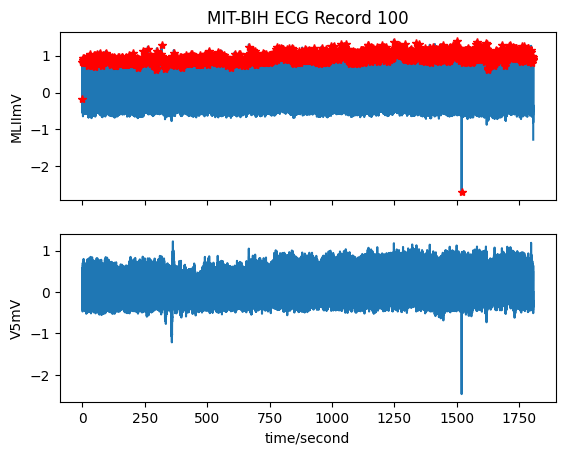

In [39]:
import wfdb
import matplotlib.pyplot as plt

# Read one sample ECG record (e.g., record 100)
record = wfdb.rdrecord('../data/100')
annotation = wfdb.rdann('../data/100', 'atr')

# Display record info
print(record.__dict__.keys())
print("Sampling frequency:", record.fs)
print("Signal shape:", record.p_signal.shape)

# Plot ECG waveform with annotations
wfdb.plot_wfdb(record=record, annotation=annotation,
               title='MIT-BIH ECG Record 100')

In [40]:
signal = record.p_signal[:,0]  # first ECG lead
print("Signal length:", len(signal))

annotation.symbol[:20]  # first 20 beat types
annotation.sample[:20]  # their positions


Signal length: 650000


array([  18,   77,  370,  662,  946, 1231, 1515, 1809, 2044, 2402, 2706,
       2998, 3282, 3560, 3862, 4170, 4466, 4764, 5060, 5346])

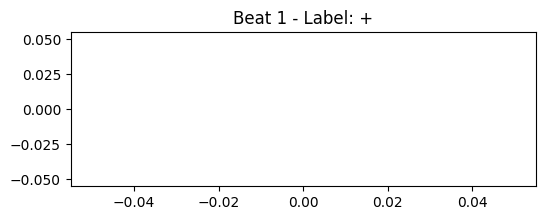

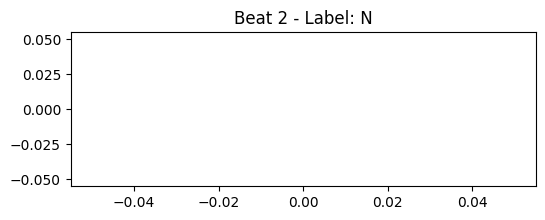

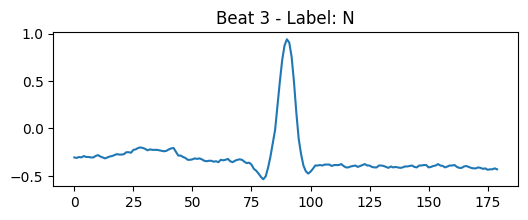

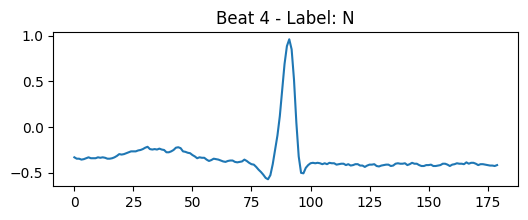

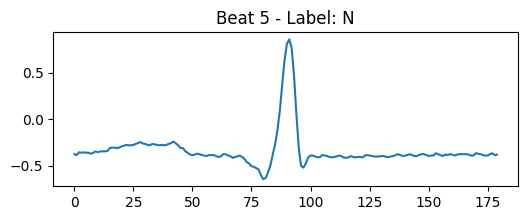

In [41]:
import numpy as np

for i, beat in enumerate(annotation.sample[:5]):
    plt.figure(figsize=(6, 2))
    plt.plot(signal[beat-90:beat+90])
    plt.title(f"Beat {i+1} - Label: {annotation.symbol[i]}")
    plt.show()


Total Records Analyzed: 5
Sampling Frequency (fs): 360 Hz
Total Duration: 2.51 hours
Total Beats: 10742


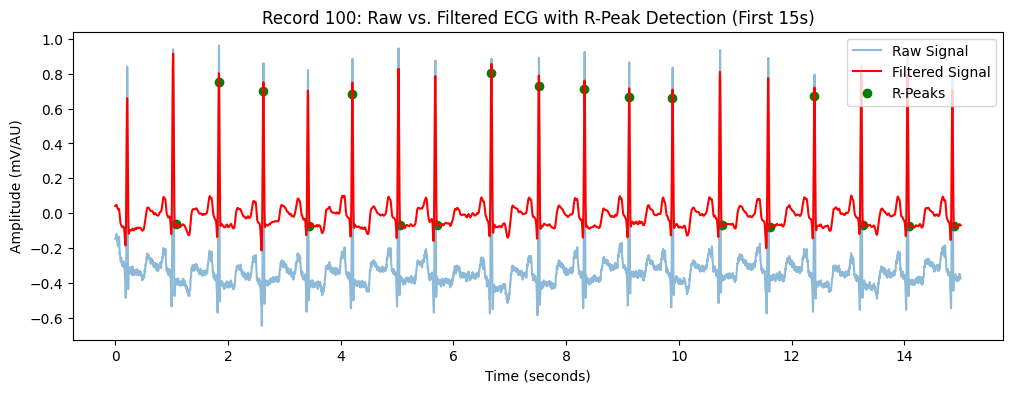

In [42]:
import wfdb
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy.signal import resample
from collections import Counter
import os

# --- Configuration ---
RECORDS = ['100', '101', '102', '103', '104'] # List of patient IDs to analyze
SAMPLING_RATE = 360 # MIT-BIH is 360 Hz

# --- 1. Comprehensive EDA on ALL records (New Goal) ---
total_duration_s = 0
total_beats = 0
for rec_name in RECORDS:
    record = wfdb.rdrecord(f'../data/{rec_name}')
    ann = wfdb.rdann(f'../data/{rec_name}', 'atr')
    total_duration_s += record.sig_len / record.fs
    total_beats += len(ann.sample)

print(f"Total Records Analyzed: {len(RECORDS)}")
print(f"Sampling Frequency (fs): {SAMPLING_RATE} Hz")
print(f"Total Duration: {total_duration_s / 60 / 60:.2f} hours")
print(f"Total Beats: {total_beats}")


# --- 2. Single Record Preprocessing & Visualization (Record 100) ---
rec_path = '../data/100'
record = wfdb.rdrecord(rec_path)
annotation = wfdb.rdann(rec_path, 'atr')
signal = record.p_signal[:, 0]
fs = record.fs

# a) Bandpass Filter (0.5 - 40 Hz) and Baseline Removal
# We'll use NeuroKit2 for robust cleaning, fulfilling the Week 2 filtering requirement
signal_clean = nk.ecg_clean(signal, sampling_rate=fs, method='neurokit', highcut=40, lowcut=0.5)

# b) R-Peak Detection (using Neurokit2's robust algorithm)
_, rpeaks = nk.ecg_peaks(signal_clean, sampling_rate=fs, method='pantompkins1985')
rpeak_indices = rpeaks['ECG_R_Peaks']

# c) Plotting Raw vs. Filtered vs. R-peaks (First 15s)
start_sec, end_sec = 0, 15
start_idx, end_idx = start_sec * fs, end_sec * fs

plt.figure(figsize=(12, 4))
plt.plot(np.arange(start_idx, end_idx) / fs, signal[start_idx:end_idx], label='Raw Signal', alpha=0.5)
plt.plot(np.arange(start_idx, end_idx) / fs, signal_clean[start_idx:end_idx], label='Filtered Signal', color='red')

# Filter R-peaks for the plot window
rpeaks_in_window = rpeak_indices[(rpeak_indices >= start_idx) & (rpeak_indices < end_idx)]
plt.scatter(rpeaks_in_window / fs, signal_clean[rpeaks_in_window], color='green', marker='o', label='R-Peaks')

plt.title('Record 100: Raw vs. Filtered ECG with R-Peak Detection (First 15s)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (mV/AU)')
plt.legend()
plt.savefig('../results/raw_filtered_rpeaks.png')

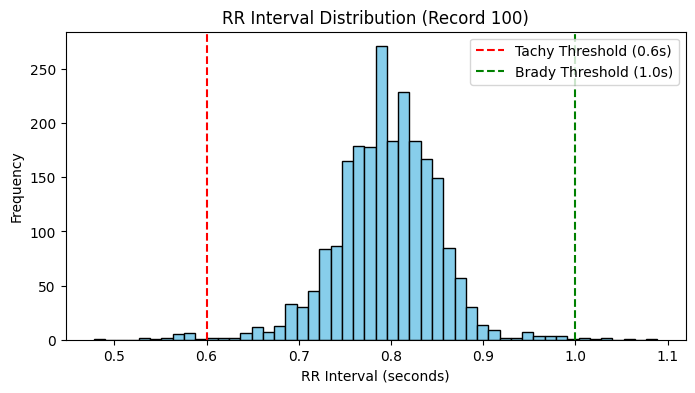

RR Intervals calculated: 2270
Tachycardia (RR < 0.6s): 18
Bradycardia (RR > 1.0s): 7
Saved R-peak indices and RR intervals for Record 100.


In [43]:
# --- RR Interval Calculation and Tachy/Brady Heuristic ---

# RR interval is the difference between successive R-peak indices
rr_intervals_s = np.diff(rpeak_indices) / fs

# Heuristic Labeling (based on the project plan: RR < 0.6s -> Tachy; RR > 1.0s -> Brady)
rr_tachy_threshold = 0.6 
rr_brady_threshold = 1.0

# Generate a basic Tachy/Brady classification for the RR intervals
# 0: Normal, 1: Bradycardia, 2: Tachycardia
rr_labels = np.zeros_like(rr_intervals_s, dtype=int)
rr_labels[rr_intervals_s > rr_brady_threshold] = 1 
rr_labels[rr_intervals_s < rr_tachy_threshold] = 2 

# --- Visualization of RR distribution ---
plt.figure(figsize=(8, 4))
plt.hist(rr_intervals_s, bins=50, color='skyblue', edgecolor='black')
plt.axvline(rr_tachy_threshold, color='red', linestyle='--', label='Tachy Threshold (0.6s)')
plt.axvline(rr_brady_threshold, color='green', linestyle='--', label='Brady Threshold (1.0s)')
plt.title('RR Interval Distribution (Record 100)')
plt.xlabel('RR Interval (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('../results/rr_interval_distribution.png')
plt.show()

print(f"RR Intervals calculated: {len(rr_intervals_s)}")
print(f"Tachycardia (RR < {rr_tachy_threshold}s): {np.sum(rr_labels == 2)}")
print(f"Bradycardia (RR > {rr_brady_threshold}s): {np.sum(rr_labels == 1)}")

# Save R-peaks and RR intervals (intermediate artifacts)
np.save(f'../data/100_rpeaks.npy', rpeak_indices)
np.save(f'../data/100_rr_intervals.npy', rr_intervals_s)
print("Saved R-peak indices and RR intervals for Record 100.")

In [44]:
# --- Full Data Loading, Preprocessing, and Segmentation (Inter-Patient Ready) ---

RECORDS = ['100', '101', '102', '103', '104']
SAMPLING_RATE = 360
WINDOW_SIZE = 180 # 0.5 seconds at 360 Hz (90 pre-peak, 90 post-peak)

X_all, y_all, patient_ids = [], [], []

# Unified Label Map (Using original MIT-BIH annotations for consistency with plan's labels)
label_map = {
    'N': 'Normal',
    'L': 'Abnormal', 'R': 'Abnormal', 'A': 'Abnormal', 'V': 'Abnormal', '/': 'Abnormal',
    # Include other common non-Normal beats for a robust binary classifier
    'f': 'Abnormal', 'F': 'Abnormal', 'j': 'Abnormal', 'E': 'Abnormal', 'J': 'Abnormal',
    'e': 'Abnormal', 'S': 'Abnormal', '+': 'Abnormal'
}

for rec_name in RECORDS:
    rec_path = f'../data/{rec_name}'
    record = wfdb.rdrecord(rec_path)
    ann = wfdb.rdann(rec_path, 'atr')
    sig = record.p_signal[:, 0]
    fs = record.fs
    
    # 1. Preprocessing: Apply Filtering (Bandpass 0.5-40Hz)
    sig_clean = nk.ecg_clean(sig, sampling_rate=fs, method='neurokit', highcut=40, lowcut=0.5)
    
    # Use the original WFDB annotations for segmentation (gold standard alignment)
    for i, idx in enumerate(ann.sample):
        label_symbol = ann.symbol[i]
        mapped_label = label_map.get(label_symbol)
        
        # Skip if the beat is unmappable or near the edges
        if mapped_label is None or mapped_label == '':
            continue
        if idx - WINDOW_SIZE // 2 < 0 or idx + WINDOW_SIZE // 2 >= len(sig_clean):
            continue
            
        # 2. Segmentation: Extract beat window
        segment = sig_clean[idx - WINDOW_SIZE // 2 : idx + WINDOW_SIZE // 2]
        
        # 3. Normalization (Z-score, per segment)
        segment_norm = (segment - np.mean(segment)) / np.std(segment)
        
        X_all.append(segment_norm)
        y_all.append(mapped_label)
        # CRITICAL: Track the patient ID for inter-patient split (Week 3/5)
        patient_ids.append(rec_name) 

# Convert to Numpy Arrays for saving
X_all = np.array(X_all)
y_all = np.array(y_all)
patient_ids = np.array(patient_ids)

# Save the full processed data, including patient IDs for inter-patient split
np.savez('../data/processed_full_interpatient.npz', X=X_all, y=y_all, patient_id=patient_ids)
print(f"✅ Saved processed data for {len(RECORDS)} patients, ready for inter-patient split!")
print(f"Total Segments: {X_all.shape[0]}, Patient IDs Tracked: {len(patient_ids)}")

✅ Saved processed data for 5 patients, ready for inter-patient split!
Total Segments: 10662, Patient IDs Tracked: 10662


In [45]:
try:
    data = np.load('../data/processed_full_interpatient.npz', allow_pickle=True)
    X_all = data['X']
    y_all = data['y']
    patient_ids = data['patient_id'] # Make sure the patient IDs are available for the split later
    
    print(f"✅ Successfully loaded X_all (segments) shape: {X_all.shape}")
    print(f"✅ Successfully loaded y_all (labels) shape: {y_all.shape}")
except FileNotFoundError:
    print("Error: processed_full_interpatient.npz not found. Please run the full preprocessing loop (Modified Cell 12).")
    raise

✅ Successfully loaded X_all (segments) shape: (10662, 180)
✅ Successfully loaded y_all (labels) shape: (10662,)


In [46]:
import numpy as np
from collections import Counter

print("Total segments:", len(y_all))
print("Label distribution:", Counter(y_all))

segment_lengths = [len(seg) for seg in X_all]
print(f"Segment length mean = {np.mean(segment_lengths):.1f}, std = {np.std(segment_lengths):.1f}")


Total segments: 10662
Label distribution: Counter({np.str_('Normal'): 6440, np.str_('Abnormal'): 4222})
Segment length mean = 180.0, std = 0.0


<Figure size 1000x400 with 0 Axes>

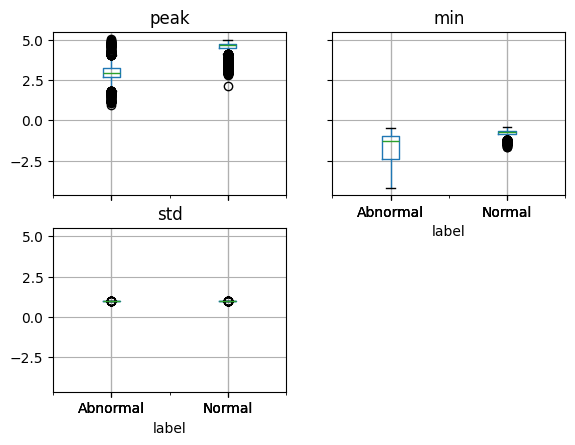

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute simple features for visualization
means = [np.mean(seg) for seg in X_all]
stds  = [np.std(seg) for seg in X_all]
peaks = [np.max(seg) for seg in X_all]
mins  = [np.min(seg) for seg in X_all]

df_feat = pd.DataFrame({
    "mean": means,
    "std": stds,
    "peak": peaks,
    "min": mins,
    "label": y_all
})

plt.figure(figsize=(10,4))
df_feat.boxplot(column=["peak","min","std"], by="label")
plt.suptitle("")
plt.title("Distribution of Basic ECG Features by Class")
plt.show()


In [48]:
df_feat.to_csv("../results/basic_features_week1.csv", index=False)
print("Saved basic feature summary for Week 1.")


Saved basic feature summary for Week 1.


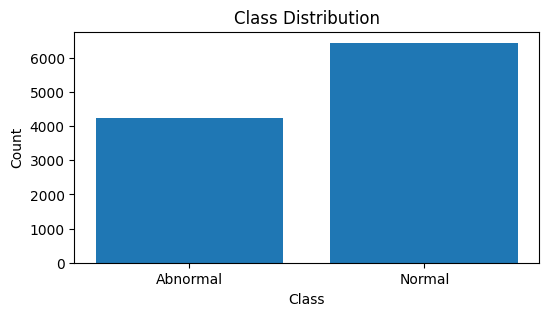

In [49]:
plt.figure(figsize=(6,3))
plt.bar(*np.unique(y_all, return_counts=True))
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


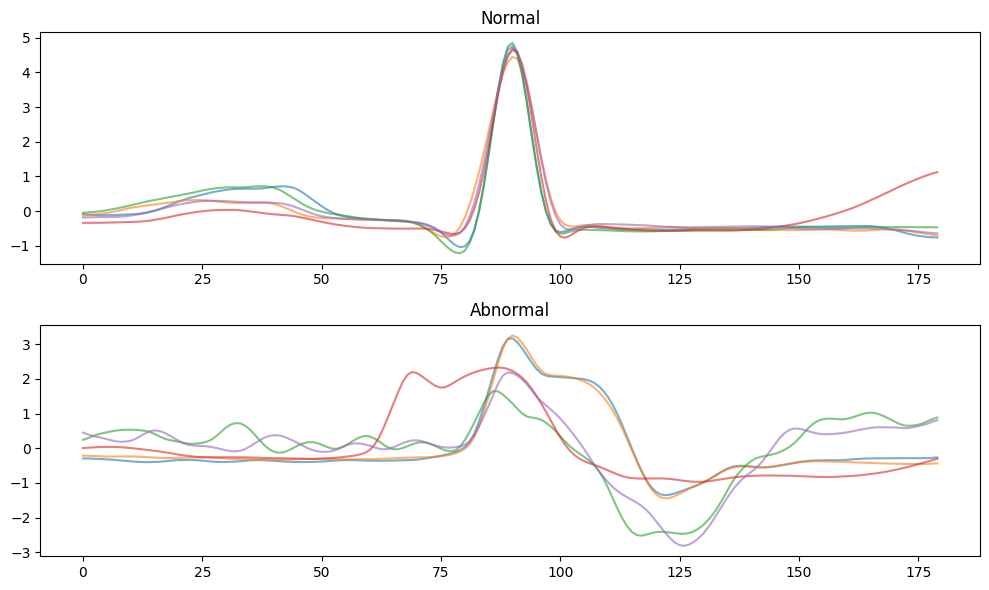

In [50]:
import random
plt.figure(figsize=(10,6))
for i, label in enumerate(["Normal","Abnormal"]):
    plt.subplot(2,1,i+1)
    samples = random.sample(list(np.where(np.array(y_all)==label)[0]), 5)
    for s in samples:
        plt.plot(X_all[s], alpha=0.6)
    plt.title(label)
plt.tight_layout()
plt.show()


In [51]:
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft
import numpy as np
import pandas as pd

features = []

for seg, label in zip(X_all, y_all):
    seg = np.array(seg)
    # ---- Time domain ----
    mean_val = np.mean(seg)
    std_val = np.std(seg)
    skew_val = skew(seg)
    kurt_val = kurtosis(seg)
    max_val = np.max(seg)
    min_val = np.min(seg)
    ptp_val = max_val - min_val
    energy_val = np.sum(seg**2)
    
    # ---- Frequency domain ----
    N = len(seg)
    freq_spectrum = np.abs(fft(seg))[:N//2]  # one-sided FFT
    freq_energy = np.sum(freq_spectrum**2)
    dominant_freq_idx = np.argmax(freq_spectrum)
    spec_entropy = entropy(freq_spectrum / np.sum(freq_spectrum))
    
    features.append([
        mean_val, std_val, skew_val, kurt_val,
        max_val, min_val, ptp_val, energy_val,
        freq_energy, dominant_freq_idx, spec_entropy,
        label
    ])

cols = [
    "mean", "std", "skew", "kurtosis",
    "max", "min", "ptp", "energy",
    "freq_energy", "dominant_freq_idx", "spectral_entropy",
    "label"
]

df_features = pd.DataFrame(features, columns=cols)

# Save for Week 2 model training
df_features.to_csv("../results/feature_dataset_week1.csv", index=False)
print("✅ Saved enriched feature dataset for Week 1:", df_features.shape)
df_features.head()


✅ Saved enriched feature dataset for Week 1: (10662, 12)


,mean,std,skew,kurtosis,max,min,ptp,energy,freq_energy,dominant_freq_idx,spectral_entropy,label
0,9.868649e-18,1.0,3.311220,11.020140,4.737963,-0.738695,5.476658,180.0,16199.962081,3,2.909308,Normal
1,2.960595e-17,1.0,3.288120,11.447440,4.877745,-0.904212,5.781956,180.0,16199.970009,3,2.955900,Normal
2,-1.727014e-17,1.0,3.255007,11.566338,4.877419,-1.379753,6.257173,180.0,16199.997822,3,2.767581,Normal
3,9.868649e-18,1.0,3.229512,11.207998,4.901207,-0.885854,5.787060,180.0,16199.938716,3,3.040632,Normal
4,1.973730e-17,1.0,3.037389,10.090473,4.758959,-0.890726,5.649685,180.0,16199.940320,3,3.031396,Normal


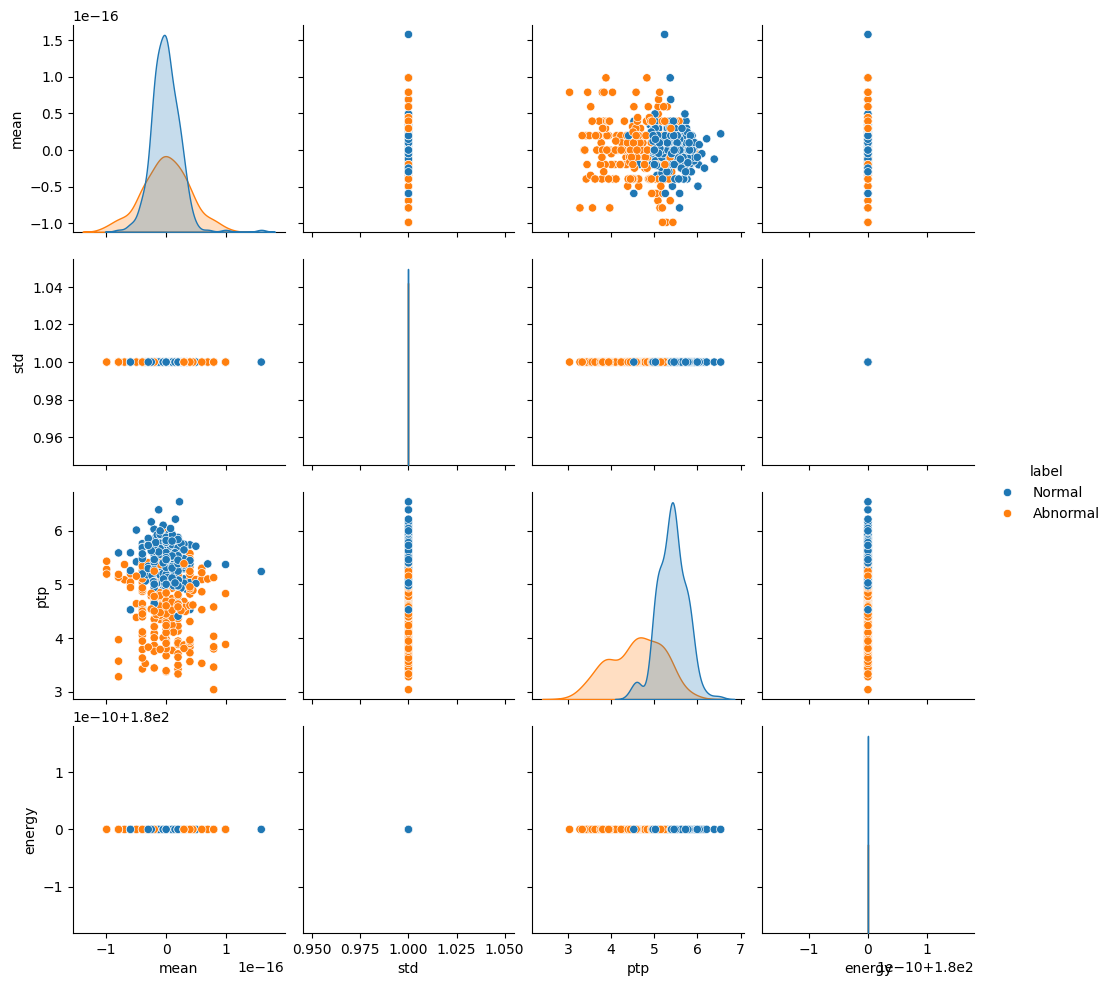

In [52]:
import seaborn as sns
sns.pairplot(df_features.sample(500), vars=["mean","std","ptp","energy"], hue="label")
plt.show()


WEEK-2

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# --- Load the Inter-Patient Ready Data ---
# Load segments (X) and labels (y_all) and patient IDs (patient_ids)
full_data = np.load('../data/processed_full_interpatient.npz', allow_pickle=True)
X_segments = full_data['X'] # The normalized 180-sample segments (Shape: N, 180)
y_labels = full_data['y'] # 'Normal' or 'Abnormal'
patient_ids = full_data['patient_id']
# Binary encoding
y_binary = pd.Series(y_labels).map({"Normal": 0, "Abnormal": 1}).values

# --- Load Tabular Features ---
# We will use the features (not segments) for classical ML models
df_features = pd.read_csv("../results/feature_dataset_week1.csv")
X_feat = df_features.drop("label", axis=1)
y_feat = df_features["label"].map({"Normal": 0, "Abnormal": 1})

# --- CRITICAL: Inter-Patient Split ---
# Split the unique patient IDs: e.g., Train on 100, 101, 102; Test on 103, 104
all_patients = np.unique(patient_ids)
train_patients = all_patients[:3]  # '100', '101', '102'
test_patients = all_patients[3:]   # '103', '104'

# Create boolean masks for the split based on patient IDs
is_train = np.isin(patient_ids, train_patients)
is_test = np.isin(patient_ids, test_patients)

# Apply the masks to the FEATURE DATA (X_feat and y_feat)
X_train = X_feat[is_train]
X_test = X_feat[is_test]
y_train = y_feat[is_train]
y_test = y_feat[is_test]

# --- Standardize Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
import joblib
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/StandardScaler_interpatient.joblib')

print("--- Inter-Patient Split Verification ---")
print(f"Train Patients: {train_patients}")
print(f"Test Patients: {test_patients}")
print(f"Training Feature Set Shape: {X_train_scaled.shape}")
print(f"Testing Feature Set Shape: {X_test_scaled.shape}")

--- Inter-Patient Split Verification ---
Train Patients: ['100' '101' '102']
Test Patients: ['103' '104']
Training Feature Set Shape: (6324, 11)
Testing Feature Set Shape: (4338, 11)


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

# Calculate class weights for imbalance handling (based on y_train from the new split)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(weights))

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight=class_weight_dict, random_state=42),
    
    "SVM": SVC(kernel='rbf', C=2, gamma='scale', class_weight=class_weight_dict, random_state=42, probability=True),
    
    "Random Forest": RandomForestClassifier(n_estimators=150, class_weight=class_weight_dict, random_state=42)
}

print("--- Retraining Models with Inter-Patient Split (Realistic Generalization) ---")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    print(f"\n📊 {name} Accuracy (Inter-Patient): {acc:.4f}")
    print(classification_report(y_test, preds, zero_division=0))

--- Retraining Models with Inter-Patient Split (Realistic Generalization) ---

📊 Logistic Regression Accuracy (Inter-Patient): 0.7679
              precision    recall  f1-score   support

           0       0.71      0.94      0.81      2245
           1       0.89      0.59      0.71      2093

    accuracy                           0.77      4338
   macro avg       0.80      0.76      0.76      4338
weighted avg       0.80      0.77      0.76      4338


📊 SVM Accuracy (Inter-Patient): 0.9308
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2245
           1       1.00      0.86      0.92      2093

    accuracy                           0.93      4338
   macro avg       0.94      0.93      0.93      4338
weighted avg       0.94      0.93      0.93      4338


📊 Random Forest Accuracy (Inter-Patient): 0.8995
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2245
           1 

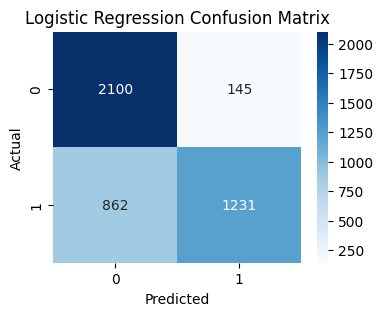

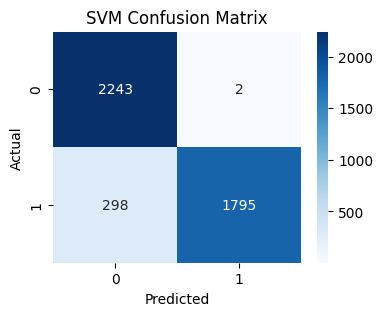

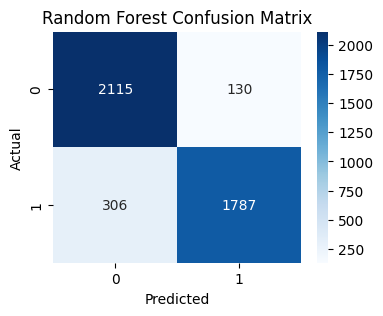

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

for name, model in models.items():
    preds = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


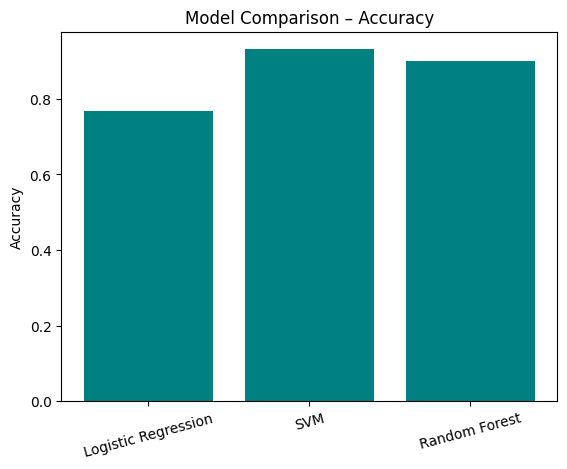

In [56]:
import numpy as np

accuracies = []
for name, model in models.items():
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

plt.bar(models.keys(), accuracies, color='teal')
plt.title("Model Comparison – Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.show()


In [57]:
import joblib
from sklearn.metrics import accuracy_score
import os # Add os module for directory creation/check

# Ensure the models directory exists (CRITICAL FOR FILE SAVING)
os.makedirs('../models', exist_ok=True) 

# --- Save ALL classical models for robustness check (New Logic) ---
for name, model in models.items():
    file_path = f"../models/{name.replace(' ','_')}_interpatient.joblib"
    joblib.dump(model, file_path)
    print(f"Saved model: {name}")

# Use the new, more realistic metrics to find the best model for report
best_model_name = max(models, key=lambda m: accuracy_score(y_test, models[m].predict(X_test_scaled)))

# Save all metrics for the final report (keep this as is)
with open("../results/week2_classical_metrics_interpatient.txt", "w") as f:
    for name, model in models.items():
        preds = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, preds)
        report = classification_report(y_test, preds, output_dict=True, zero_division=0)
        f.write(f"=== {name} (Inter-Patient) ===\n")
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"Precision (Abnormal): {report['1']['precision']:.4f}\n")
        f.write(f"Recall (Abnormal/Sensitivity): {report['1']['recall']:.4f}\n")
        f.write(f"F1-Score (Abnormal): {report['1']['f1-score']:.4f}\n\n")

print(f"\n The best classical model for the report is ({best_model_name}).")
print("Week 2 metrics saved to 'week2_classical_metrics_interpatient.txt'.")

Saved model: Logistic Regression
Saved model: SVM
Saved model: Random Forest

 The best classical model for the report is (SVM).
Week 2 metrics saved to 'week2_classical_metrics_interpatient.txt'.


In [58]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Loaded SVM model for SHAP analysis.


  0%|          | 0/50 [00:00<?, ?it/s]

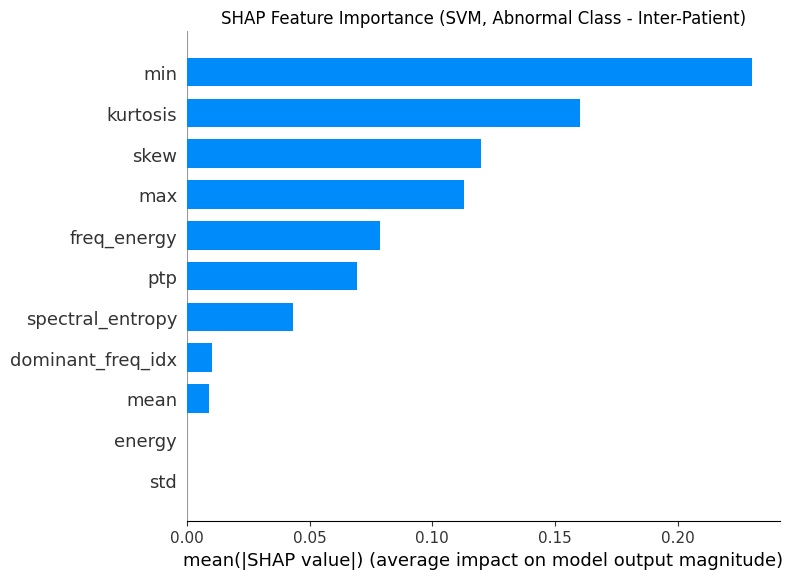

Generated SHAP feature importance plot for SVM.


In [59]:
import shap
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- 1. Load the Best Classical Model (SVM) ---
try:
    best_model = joblib.load("../models/SVM_interpatient.joblib")
    print("Loaded SVM model for SHAP analysis.")
except FileNotFoundError:
    print("Error: The SVM_interpatient.joblib file was not found. Please ensure Cell 58 and Cell 61 ran successfully.")
    raise

# --- 2. Recreate Scaled Data (CRITICAL for a self-contained cell) ---
full_data = np.load('../data/processed_full_interpatient.npz', allow_pickle=True)
patient_ids = full_data['patient_id']
df_features = pd.read_csv("../results/feature_dataset_week1.csv")
X_feat = df_features.drop("label", axis=1)

all_patients = np.unique(patient_ids)
train_patients = all_patients[:3] 
test_patients = all_patients[3:]   

is_train = np.isin(patient_ids, train_patients)
is_test = np.isin(patient_ids, test_patients)

X_train = X_feat[is_train]
X_test = X_feat[is_test]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# --- 3. Define SHAP Data Sets (NumPy Arrays) ---

# Background data (NumPy array) - used for the explainer's reference
background_data = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# Explanation data (NumPy array) - samples to explain
X_shap = X_test_scaled_df.sample(n=50, random_state=42)
X_shap_values = X_shap.values


# --- 4. Define Prediction Wrapper Function ---
# KernelExplainer needs to know how to get probabilities for the target class (index 1).
def predict_abnormal_proba(X):
    # predict_proba returns an array of shape (N, 2), we want the second column (class 1)
    return best_model.predict_proba(X)[:, 1]

# --- 5. Explain the Model ---
# Initialize KernelExplainer with the custom wrapper function and NumPy background data
explainer = shap.KernelExplainer(predict_abnormal_proba, background_data)

# Calculate SHAP values (The output shape will be (N, Features))
# This calculation is for the single target class (Abnormal)
shap_values_single_output = explainer.shap_values(X_shap_values, nsamples=100) 


# --- 6. Visualize Global Feature Importance (No slicing needed, already single-output) ---

plt.figure(figsize=(8, 5))

# Pass the single-output SHAP values and the NumPy array for plotting
shap.summary_plot(
    shap_values_single_output, 
    X_shap_values,
    plot_type="bar", 
    show=False, 
    # Use feature names from the original DataFrame columns
    feature_names=X_test.columns.tolist()
)

plt.title("SHAP Feature Importance (SVM, Abnormal Class - Inter-Patient)")
plt.tight_layout()
plt.savefig('../results/shap_feature_importance_svm.png')
plt.show()

print(f"Generated SHAP feature importance plot for SVM.")

WEEK-3

In [60]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd # Needed to map labels

# --- Load the Inter-Patient Ready Data and Split Masks ---
full_data = np.load('../data/processed_full_interpatient.npz', allow_pickle=True)
X_segments = full_data['X'] # The normalized 180-sample segments
y_labels = full_data['y'] # 'Normal' or 'Abnormal'
patient_ids = full_data['patient_id']

# Determine the split based on the patient IDs used in the classical ML section
all_patients = np.unique(patient_ids)
train_patients = all_patients[:3]  # '100', '101', '102'
test_patients = all_patients[3:]   # '103', '104'

# Create boolean masks for the split
is_train = np.isin(patient_ids, train_patients)
is_test = np.isin(patient_ids, test_patients)

# Apply the masks to the SEGMENT DATA
X_train_segments = X_segments[is_train]
X_test_segments = X_segments[is_test]
y_train = pd.Series(y_labels[is_train]).map({"Normal": 0, "Abnormal": 1}).values
y_test = pd.Series(y_labels[is_test]).map({"Normal": 0, "Abnormal": 1}).values


# --- Reshape for CNN/LSTM input (Add the channel dimension) ---
X_train_segments = X_train_segments[..., np.newaxis]
X_test_segments = X_test_segments[..., np.newaxis]

print("--- Inter-Patient Split Applied to Segments ---")
print("Total Segments loaded:", X_segments.shape)
print(f"Train Segments Shape: {X_train_segments.shape}")
print(f"Test Segments Shape: {X_test_segments.shape}")

--- Inter-Patient Split Applied to Segments ---
Total Segments loaded: (10662, 180)
Train Segments Shape: (6324, 180, 1)
Test Segments Shape: (4338, 180, 1)


In [61]:
# The split is already done in the previous cell. We just rename variables
X_train = X_train_segments
X_test = X_test_segments

# The segments are already properly reshaped to (N, 180, 1) in the previous cell.

print(f"Train shape (Inter-Patient): {X_train.shape} Test shape (Inter-Patient): {X_test.shape}")

Train shape (Inter-Patient): (6324, 180, 1) Test shape (Inter-Patient): (4338, 180, 1)


MODEL 1: 1D CNN

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

cnn = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()


C:\Users\Sumit Sharma\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 176, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 88, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 84, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 42, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       172,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,657 (713.50 KB)

 Trainable params: 182,657 (713.50 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
from sklearn.utils import compute_class_weight

# Calculate weights to adjust for class imbalance in the INTER-PATIENT split
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to a dictionary mapping class index (0 and 1) to weight
class_weight_dict = dict(enumerate(class_weights))
print("Calculated Class Weights (Inter-Patient Split):", class_weight_dict)

Calculated Class Weights (Inter-Patient Split): {0: np.float64(0.7537544696066746), 1: np.float64(1.4852043212775952)}


In [64]:
# Pass the calculated class weights here
history = cnn.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=64, 
    validation_split=0.2, 
    verbose=1,
    class_weight=class_weight_dict  
)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9830 - loss: 0.0899 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9913 - loss: 0.0401 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9937 - loss: 0.0338 - val_accuracy: 1.0000 - val_loss: 5.1188e-04
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9935 - loss: 0.0288 - val_accuracy: 1.0000 - val_loss: 7.3729e-04
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9925 - loss: 0.0302 - val_accuracy: 1.0000 - val_loss: 2.7390e-04
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9945 - loss: 0.0230 - val_accuracy: 1.0000 - val_loss: 1.8057e-04
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9943 - loss: 0.0245 - val_accuracy: 1.0000 - val_loss: 1.4661e-04
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9951 - loss: 0.0240 - val_

In [65]:
from sklearn.metrics import classification_report

y_pred = (cnn.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.72      0.87      0.79      2245
           1       0.82      0.63      0.71      2093

    accuracy                           0.76      4338
   macro avg       0.77      0.75      0.75      4338
weighted avg       0.77      0.76      0.75      4338



Model 2: LSTM (Optional – Sequential Dependency Model)

In [66]:
from tensorflow.keras.layers import LSTM

lstm = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.summary()

lstm.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)


C:\Users\Sumit Sharma\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8146 - loss: 0.4835 - val_accuracy: 0.4379 - val_loss: 1.2644
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.8207 - loss: 0.3702 - val_accuracy: 7.9051e-04 - val_loss: 1.1175
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.8300 - loss: 0.4343 - val_accuracy: 0.0893 - val_loss: 1.3509
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.8304 - loss: 0.4912 - val_accuracy: 7.9051e-04 - val_loss: 1.5728
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8302 - loss: 0.4580 - val_accuracy: 7.9051e-04 - val_loss: 2.2041
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.8288 - loss: 0.4841 - val_accuracy: 7.9051e-04 - val_loss: 1.4996
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8539 - loss: 0.4432 - val_accuracy: 7.9051e-04 - val_loss: 2.0045
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8290 - loss: 0.4813 -

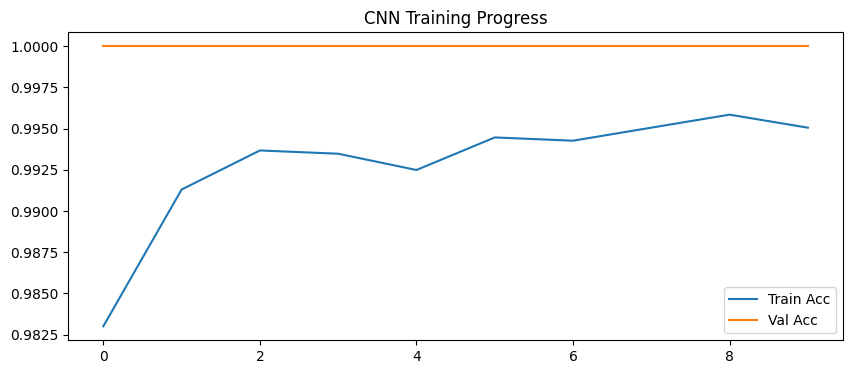

In [67]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('CNN Training Progress'); plt.show()


WEEK-4

Sample index: 5, Actual Label (1=Abnormal): 0


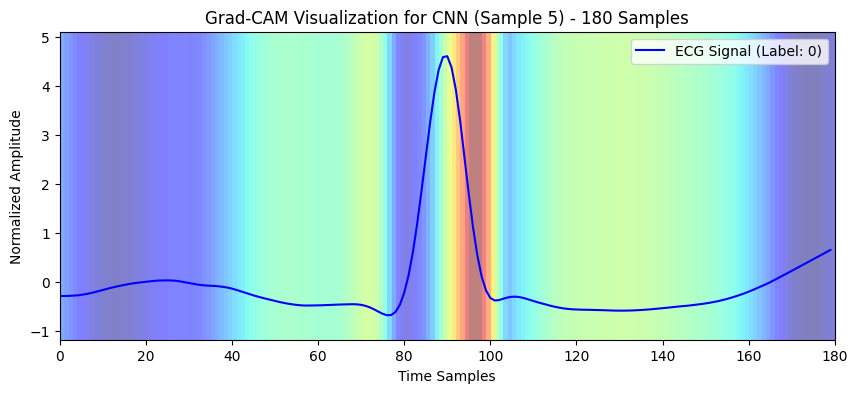

In [68]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
import matplotlib.pyplot as plt

# --- 1. Define Input and Rebuild Layer Chain ---

# Explicitly define the input tensor shape
input_tensor = tf.keras.Input(shape=(X_test.shape[1], 1))

# Initialize variables to hold the key Tensors
last_conv_output_tensor = None
final_output_tensor = None

# Iterate through the layers of the trained CNN model, manually chaining them
x = input_tensor
conv_layers_found = []

for layer in cnn.layers:
    x = layer(x) # Apply the layer to the current tensor 'x'
    
    # Store all convolutional layers
    if isinstance(layer, tf.keras.layers.Conv1D):
        conv_layers_found.append(x)
        
    # The final output is the output of the last layer
    if layer.name == cnn.layers[-1].name:
        final_output_tensor = x

# The output of the LAST Conv1D layer is the last element we stored
if conv_layers_found:
    last_conv_output_tensor = conv_layers_found[-1]

# 2. Define the Grad-CAM model

if last_conv_output_tensor is None or final_output_tensor is None:
    # This should now only trigger if the CNN structure is fundamentally broken
    raise RuntimeError("Failed to correctly identify layer outputs in the CNN chain (check model structure).")

grad_model = models.Model(
    inputs=input_tensor,
    outputs=[last_conv_output_tensor, final_output_tensor]
)

# --- 3. Grad-CAM Logic ---

# Choose a test sample (e.g., an abnormal beat at index 5)
sample_index = 5
sample = X_test[sample_index].reshape(1, X_test.shape[1], 1)
label = y_test[sample_index]
print(f"Sample index: {sample_index}, Actual Label (1=Abnormal): {label}")

# Compute gradients
with tf.GradientTape() as tape:
    # Use the sample as input to the grad_model
    conv_outputs, predictions = grad_model(sample)
    # The loss is the predicted probability for the target class (index 0 in the sigmoid output)
    loss = predictions[:, 0]

# Gradients of loss wrt conv layer output
grads = tape.gradient(loss, conv_outputs)

# Global average pooling across time dimension (axis 1 for Conv1D output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Weight the feature maps by pooled gradients
conv_outputs = conv_outputs.numpy()[0]
pooled_grads = pooled_grads.numpy()

for i in range(pooled_grads.shape[-1]):
    conv_outputs[:, i] *= pooled_grads[i]

# Generate heatmap
heatmap = np.mean(conv_outputs, axis=-1)
heatmap = np.maximum(heatmap, 0)

# Normalize the heatmap
max_val = np.max(heatmap)
if max_val > 0:
    heatmap /= max_val
else:
    print("Warning: Max heatmap value is 0. Cannot normalize.")

# --- 4. Visualize Grad-CAM ---

# Use a slightly smaller figsize for the 180-sample segment
plt.figure(figsize=(10, 4)) 

# PLOT: Limit the ECG signal data to 180 points
plt.plot(X_test[sample_index][:180], label=f'ECG Signal (Label: {label})', color='blue')

# Interpolate heatmap to match signal length (180) for plotting
upsampled_heatmap = np.interp(
    # Target range: 0 to 179 for 180 samples
    np.linspace(0, 179, 180), 
    np.linspace(0, len(X_test[sample_index]) - 1, len(heatmap)),
    heatmap
)

# Plot the heatmap
plt.imshow(
    upsampled_heatmap[np.newaxis, :],
    # EXTENT: Set the X-axis limit to 180
    extent=[0, 180, np.min(X_test[sample_index]) - 0.5, np.max(X_test[sample_index]) + 0.5], 
    cmap='jet',
    alpha=0.5,
    aspect='auto'
)
plt.title(f"Grad-CAM Visualization for CNN (Sample {sample_index}) - 180 Samples")
plt.xlabel("Time Samples")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.show()

WEEK-5

CNN Test Accuracy: 0.7554
LSTM Test Accuracy: 0.5175
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


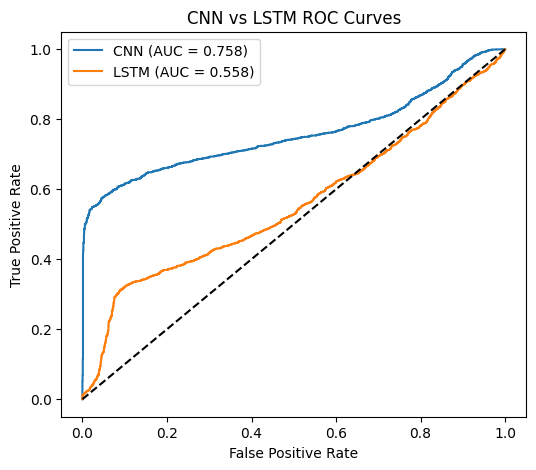

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Evaluate CNN
cnn_loss, cnn_acc = cnn.evaluate(X_test, y_test, verbose=0)
print(f"CNN Test Accuracy: {cnn_acc:.4f}")

# Evaluate LSTM
lstm_loss, lstm_acc = lstm.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Accuracy: {lstm_acc:.4f}")

# CNN ROC Curve
y_pred_cnn = cnn.predict(X_test).ravel()
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# LSTM ROC Curve
y_pred_lstm = lstm.predict(X_test).ravel()
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot both ROC curves
plt.figure(figsize=(6,5))
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {roc_auc_cnn:.3f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {roc_auc_lstm:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CNN vs LSTM ROC Curves")
plt.legend()
plt.show()

In [70]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

input_layer = Input(shape=(X_train.shape[1], 1))

# CNN block
x = Conv1D(64, 5, activation='relu')(input_layer)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# LSTM block
x = LSTM(64, return_sequences=False)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

output_layer = Dense(1, activation='sigmoid')(x)

cnn_lstm = Model(inputs=input_layer, outputs=output_layer)
cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm.summary()

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(weights))

# --- Define Callbacks (Project Requirement) ---
callbacks = [
    # Stop training when the validation loss hasn't improved for 5 epochs
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    # Save the model weights corresponding to the best validation loss
    ModelCheckpoint(filepath='../models/best_cnn_lstm_interpatient.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

print("\n--- Training CNN-LSTM Model with Callbacks and Inter-Patient Split ---")

# --- Retraining the model using the correct data and callbacks ---
cnn_lstm_history = cnn_lstm.fit(
    X_train, y_train,
    epochs=50, # Setting high, EarlyStopping will manage it
    batch_size=64,
    validation_split=0.2, # Using 20% of the TRAIN set for internal validation
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 180, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 176, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,521 (138.75 KB)

 Trainable params: 35,521 (138.75 KB)

 Non-trainable params: 0 (0.00 B)


--- Training CNN-LSTM Model with Callbacks and Inter-Patient Split ---
Epoch 1/50
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8426 - loss: 0.4803
Epoch 1: val_loss improved from None to 0.06418, saving model to ../models/best_cnn_lstm_interpatient.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9041 - loss: 0.3262 - val_accuracy: 0.9976 - val_loss: 0.0642
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9756 - loss: 0.1146
Epoch 2: val_loss improved from 0.06418 to 0.04735, saving model to ../models/best_cnn_lstm_interpatient.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9773 - loss: 0.1061 - val_accuracy: 0.9976 - val_loss: 0.0473
Epoch 3/50
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9892 - loss: 0.0827
Epoch 3: val_loss improved from 0.04735 to 0.00850, saving model to ../models/best_cnn_lstm_interpatient.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9877 - loss: 0.0811 - val_accuracy: 0.9984 - val_loss: 0.

In [71]:
from sklearn.metrics import classification_report
import os
import tensorflow as tf

# Load the best weights saved by the ModelCheckpoint callback
best_model_path = '../models/best_cnn_lstm_interpatient.keras'
if os.path.exists(best_model_path):
    cnn_lstm.load_weights(best_model_path)
    print(f"Loaded best weights from {best_model_path}.")
else:
    print("Could not load best weights. Using final epoch weights.")

# Evaluate on the unseen test set
y_pred = (cnn_lstm.predict(X_test) > 0.5).astype(int)

print("\n=== YOUR CNN-LSTM Model (Inter-Patient Test Set) ===")
print(classification_report(y_test, y_pred, zero_division=0))

# Saving the final model
cnn_lstm.save('../models/cnn_lstm_final_interpatient.keras')

print("CNN-LSTM Model trained, evaluated, and saved.")

Loaded best weights from ../models/best_cnn_lstm_interpatient.keras.
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

=== YOUR CNN-LSTM Model (Inter-Patient Test Set) ===
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      2245
           1       0.99      0.21      0.35      2093

    accuracy                           0.62      4338
   macro avg       0.78      0.60      0.54      4338
weighted avg       0.78      0.62      0.54      4338

CNN-LSTM Model trained, evaluated, and saved.


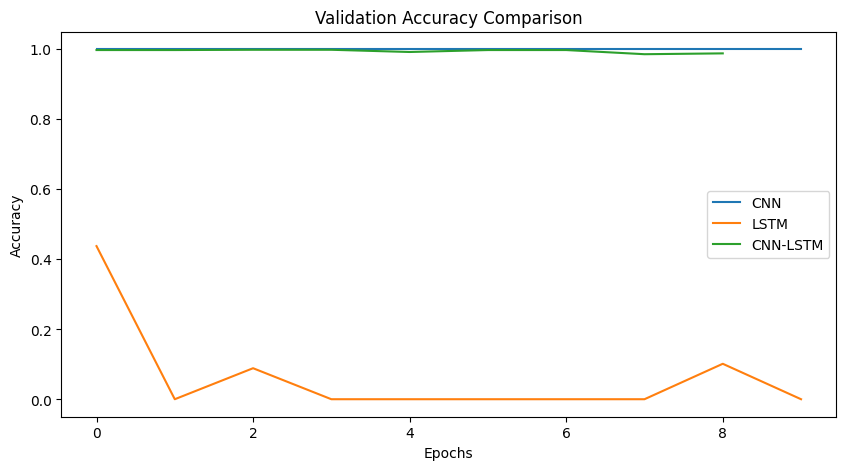

In [72]:
plt.figure(figsize=(10,5))
plt.plot(history.history['val_accuracy'], label='CNN')
plt.plot(lstm.history.history['val_accuracy'], label='LSTM')
plt.plot(cnn_lstm_history.history['val_accuracy'], label='CNN-LSTM')
plt.legend()
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [73]:
from sklearn.metrics import classification_report

for model, name in zip([cnn, lstm, cnn_lstm], ["CNN", "LSTM", "CNN-LSTM"]):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"\n=== {name} Model ===")
    print(classification_report(y_test, y_pred))

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

=== CNN Model ===
              precision    recall  f1-score   support

           0       0.72      0.87      0.79      2245
           1       0.82      0.63      0.71      2093

    accuracy                           0.76      4338
   macro avg       0.77      0.75      0.75      4338
weighted avg       0.77      0.76      0.75      4338

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

=== LSTM Model ===
              precision    recall  f1-score   support

           0       0.52      1.00      0.68      2245
           1       0.00      0.00      0.00      2093

    accuracy                           0.52      4338
   macro avg       0.26      0.50      0.34      4338
weighted avg       0.27      0.52      0.35      4338

 19/136 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

C:\Users\Sumit Sharma\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sumit Sharma\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sumit Sharma\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

=== CNN-LSTM Model ===
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      2245
           1       0.99      0.21      0.35      2093

    accuracy                           0.62      4338
   macro avg       0.78      0.60      0.54      4338
weighted avg       0.78      0.62      0.54      4338



In [74]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score
import joblib
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft
import pandas as pd
import os

# --- Assumptions ---
# X_test, y_test (inter-patient segments) are in scope.
# scaler (StandardScaler fit on classical training data) is in scope.
# cnn, cnn_lstm (DL models with best weights loaded) are in scope.

# --- 1. Load Classical Models ---
try:
    rf_model = joblib.load("../models/Random_Forest_interpatient.joblib")
    svm_model = joblib.load("../models/SVM_interpatient.joblib")
    # Assuming DL models (cnn, cnn_lstm) are loaded or in memory
except FileNotFoundError:
    print("Error: Please ensure all models (RF, SVM, CNN, CNN-LSTM) are saved/loaded correctly before running robustness.")
    raise

# --- 2. Creating Noisy Test Set (Same as provided previously) ---
NOISE_STD_DEV = 0.1 
noise = np.random.normal(0, NOISE_STD_DEV, X_test.shape)
X_test_noisy = X_test + noise

print(f"--- Robustness Check: Added Gaussian Noise (STD={NOISE_STD_DEV}) ---")

# Helper function to extract the same features used in Week 3
def extract_features(segment_array):
    features = []
    for seg in segment_array:
        # Note: Segments are (180, 1) or (180,); we ensure they are 1D for feature calculation
        seg = seg.flatten()
        
        # Time Domain Features
        mean_val = np.mean(seg)
        std_val = np.std(seg)
        skew_val = skew(seg)
        kurt_val = kurtosis(seg)
        max_val = np.max(seg)
        min_val = np.min(seg)
        ptp_val = max_val - min_val
        energy_val = np.sum(seg**2)
        
        # Frequency Domain Features
        N = len(seg)
        # Use rfft for real input for efficiency
        freq_spectrum = np.abs(np.fft.rfft(seg))
        freq_energy = np.sum(freq_spectrum**2)
        dominant_freq_idx = np.argmax(freq_spectrum)
        # Handle zero division for entropy calculation if needed
        normalized_spectrum = freq_spectrum / (np.sum(freq_spectrum) + 1e-9) 
        spec_entropy = entropy(normalized_spectrum)
        
        features.append([mean_val, std_val, skew_val, kurt_val, max_val, min_val, ptp_val, energy_val, freq_energy, dominant_freq_idx, spec_entropy])
    return np.array(features)

robustness_results = []

# --- 3. Evaluating Deep Learning Models on Noisy Data ---
dl_models = {"CNN": cnn, "CNN-LSTM": cnn_lstm} 

for name, model in dl_models.items():
    y_pred_noisy = (model.predict(X_test_noisy, verbose=0) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred_noisy)
    report = classification_report(y_test, y_pred_noisy, output_dict=True, zero_division=0)
    
    print(f"\n[DL Model] {name} Accuracy on NOISY Data: {acc:.4f}")
    print(classification_report(y_test, y_pred_noisy, zero_division=0))
    
    robustness_results.append({
        'Model': name, 
        'Type': 'DL', 
        'Accuracy (Noisy)': acc, 
        'Recall_Abnormal (Noisy)': report['1']['recall']
    })

# --- 4. Evaluating Classical Models on Noisy Data ---
X_test_noisy_feat = extract_features(X_test_noisy)
X_test_noisy_scaled = scaler.transform(X_test_noisy_feat) # Use original scaler

classical_models = {"Random Forest": rf_model, "SVM": svm_model}

for name, model in classical_models.items():
    y_pred_noisy = model.predict(X_test_noisy_scaled)
    acc = accuracy_score(y_test, y_pred_noisy)
    report = classification_report(y_test, y_pred_noisy, output_dict=True, zero_division=0)
    
    print(f"\n[Classical Model] {name} Accuracy on NOISY Data: {acc:.4f}")
    print(classification_report(y_test, y_pred_noisy, zero_division=0))
    
    robustness_results.append({
        'Model': name, 
        'Type': 'Classical', 
        'Accuracy (Noisy)': acc, 
        'Recall_Abnormal (Noisy)': report['1']['recall']
    })
    
# --- 5. Saving Results ---
df_robustness = pd.DataFrame(robustness_results)
df_robustness.to_csv('../results/model_robustness_results.csv', index=False)
print("\n Robustness results saved to 'model_robustness_results.csv'.")

--- Robustness Check: Added Gaussian Noise (STD=0.1) ---

[DL Model] CNN Accuracy on NOISY Data: 0.7584
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      2245
           1       0.80      0.67      0.73      2093

    accuracy                           0.76      4338
   macro avg       0.77      0.76      0.76      4338
weighted avg       0.76      0.76      0.76      4338


[DL Model] CNN-LSTM Accuracy on NOISY Data: 0.6134
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      2245
           1       0.99      0.20      0.33      2093

    accuracy                           0.61      4338
   macro avg       0.78      0.60      0.53      4338
weighted avg       0.77      0.61      0.54      4338


[Classical Model] Random Forest Accuracy on NOISY Data: 0.9133
              precision    recall  f1-score   support

           0       0.87      0.99      0.92      2245
           1     

C:\Users\Sumit Sharma\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
